In [3]:
import os
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import msgpack
import gzip
import pandas as pd
from collections import OrderedDict
from tqdm import tqdm_notebook as tqdm
from datetime import datetime
import pytz
import utils as sw_util
%matplotlib inline

data_root = os.path.join(os.environ['HOME'], 'vl/StopWatch/scripts/downloads')

In [10]:
base_dir = sorted(glob('/Users/vicenteperissempere/Box/StopWatch-Data/data'))[0]
print(base_dir)

/Users/vicenteperissempere/Box/StopWatch-Data/data


In [3]:
idx = -2
accel_path = sorted(glob(os.path.join(base_dir, 'AppData/Documents/data/accel-*.msgpack.gz')))[idx]
print os.path.basename(accel_path)
motion_path = sorted(glob(os.path.join(base_dir, 'AppData/Documents/data/motion-*.msgpack.gz')))[idx]
print os.path.basename(motion_path)

IndexError: list index out of range

In [74]:
with gzip.open(accel_path, 'r') as f:
    data = msgpack.load(f)
    for key, values in data.iteritems():
        print key, len(values)
    accel = pd.DataFrame(data)

with gzip.open(motion_path, 'r') as f:
    motion = msgpack.load(f)
    for key, values in motion.iteritems():
        print key, len(values)

date 231
x 231
z 231
y 231
confidence 0
cycling 0
automotive 0
walking 0
running 0
unknown 0
date 0
stationary 0


In [4]:
plt.plot(data['date'], accel.x)
plt.plot(data['date'], accel.y)
plt.plot(data['date'], accel.z)
total = np.sqrt(accel.x ** 2 + accel.y ** 2 + accel.z ** 2)
plt.plot(data['date'], total)

# HACK copied this over
activity_types = ['stationary', 'walking', 'running', 'automotive', 'cycling', 'unknown']
cmap = plt.get_cmap('Pastel1')
colors = cmap(np.linspace(0, 1, len(activity_types)))
rows = [r for _, r in pd.DataFrame(motion).iterrows()]
for item, next_item in zip(rows[:-1], rows[1:]):
    label = item[activity_types].idxmax(axis=1)
    print 'hi', item.date, next_item.date
    plt.plot(
        [item.date, next_item.date], [8, 8],
        linewidth=15, color=colors[activity_types.index(label)],
        label=label, solid_capstyle='butt')

# HACK make sure we have unique labels in legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(
    by_label.values(), by_label.keys(),
    loc='center left', bbox_to_anchor=(1, 0.5))
None

NameError: name 'data' is not defined

2017-10-10 17:00:00-07:00 1507680000.0


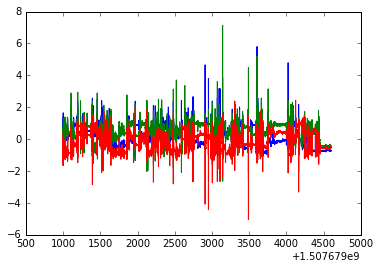

In [38]:
samples = sw_util._load_data(os.path.join(data_root, 'p1602-s3132-20171013T234015645Z.bin'))
print sw_util._parse_date(samples.start_date), samples.start_date
plt.plot(samples.date, samples.x)
plt.plot(samples.date, samples.y)
plt.plot(samples.date, samples.z)

# samples 180467


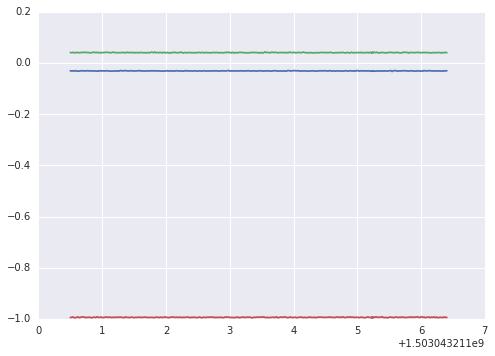

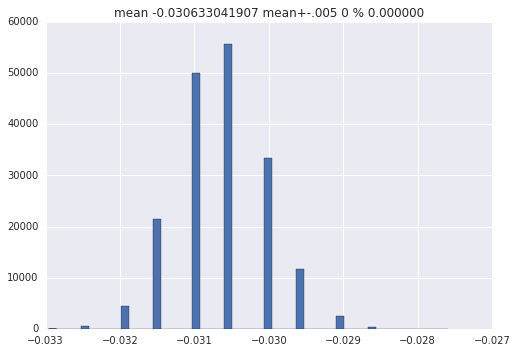

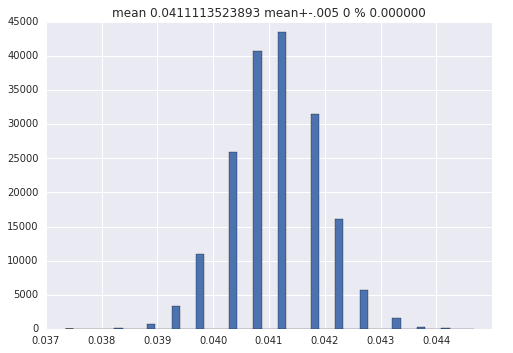

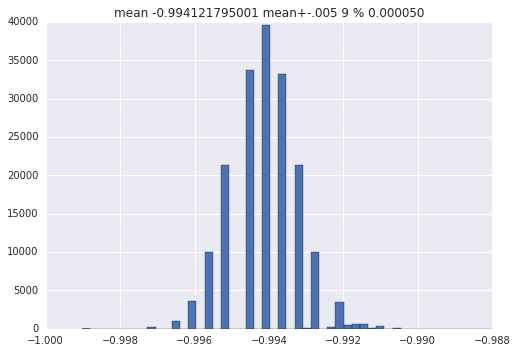

In [149]:
# This file was taken while the watch was charging
filename = 'p1602-s796-20170819T033444782Z.bin'

samples = _load_data(os.path.join(
    os.environ['HOME'],
    'vl/StopWatch/scripts/downloads', filename))
print '# samples', len(samples.date)
idx = 10*60
idx_end=idx+(5*60)
plt.plot(samples.date[idx:idx_end], samples.x[idx:idx_end])
plt.plot(samples.date[idx:idx_end], samples.y[idx:idx_end])
plt.plot(samples.date[idx:idx_end], samples.z[idx:idx_end])

def _render_accel_hist(items, label):
    # HACK to see if float32 matters items = np.array(items).astype(np.float32)
    plt.figure()
    #plt.xlim([-2, 2])
    mean = np.mean(items)
    deviations = np.count_nonzero(np.abs(items-mean)>.005)
    plt.title('mean {} mean+-.005 {} % {:02f}'.format(
        mean,
        deviations,
        deviations/float(len(items)),
    ))
    plt.hist(np.clip(items, -2, 2), bins=50, label=label)
_render_accel_hist(samples.x, 'x')
_render_accel_hist(samples.y, 'y')
_render_accel_hist(samples.z, 'z')

In [50]:
filenames = glob(os.path.join(os.environ['HOME'], 'vl/StopWatch/scripts/downloads/p1577*.bin'))
loaded = [] # uncomment when loaded files doesn't exist yet
loaded_files = {filename for _, filename in loaded}
for filename in tqdm(filenames):
    if filename in loaded_files:
        continue
    samples = sw_util._load_data(filename)
    if samples is not None:
        loaded.append((samples, filename))

In [51]:
def _participant_from_file(fn):
    p = os.path.basename(fn).split('-')[0]
    assert p[0] == 'p', 'found unexpected ID {}'.format(p)
    return p

ranges_by_participant = {}

for samples, filename in sorted(loaded, key=lambda (samples, _): samples.start_date):
    participant = _participant_from_file(filename)
    ranges = ranges_by_participant.setdefault(participant, [])
    if isinstance(samples, data_pb2.AccelerometerSamples):
        st = sw_util._parse_date(samples.start_date)
        end = sw_util._parse_date(samples.end_date)
        if not ranges:
            ranges.append((st, end))
            continue
        r_st, r_end = ranges[-1]
        if st <= r_end:
            # if the current sample starts before or at the end of the current range
            # then we should extend the range
            ranges[-1] = (r_st, end)
        else:
            # otherwise, we should start a new range
            ranges.append((st, end))

from datetime import timedelta
for participant, ranges in ranges_by_participant.iteritems():
    total = timedelta()
    print 'participant', participant
    for st, end in ranges:
        st = st.replace(microsecond=0)
        total += end.replace(microsecond=0)-st
        print '\t', st.isoformat(), 'duration', end.replace(microsecond=0)-st
    print '\ttotal time', total

participant p1577
	2017-10-05T17:00:00-07:00 duration 3:00:00
	2017-10-06T10:00:00-07:00 duration 9:00:00
	2017-10-06T20:00:00-07:00 duration 1:00:00
	2017-10-07T10:00:00-07:00 duration 6:00:00
	2017-10-08T12:00:00-07:00 duration 7:00:00
	total time 1 day, 2:00:00


2017-10-01 14:00:00-07:00 73334 /Users/carlos/vl/StopWatch/scripts/downloads/p1965-s1995-20171002T112410938Z.bin
2017-10-01 08:00:00-07:00 179009 /Users/carlos/vl/StopWatch/scripts/downloads/p1965-s1999-20171002T112413527Z.bin
2017-10-01 05:00:00-07:00 97246 /Users/carlos/vl/StopWatch/scripts/downloads/p1965-s2017-20171002T222615227Z.bin
2017-10-01 06:00:00-07:00 179013 /Users/carlos/vl/StopWatch/scripts/downloads/p1965-s2018-20171002T222617671Z.bin
2017-10-01 06:00:00-07:00 179013 /Users/carlos/vl/StopWatch/scripts/downloads/p1965-s2019-20171002T222617897Z.bin
2017-10-01 07:00:00-07:00 179071 /Users/carlos/vl/StopWatch/scripts/downloads/p1965-s2020-20171002T222620001Z.bin
2017-10-01 09:00:00-07:00 179100 /Users/carlos/vl/StopWatch/scripts/downloads/p1965-s2021-20171002T222622359Z.bin
2017-10-01 10:00:00-07:00 179164 /Users/carlos/vl/StopWatch/scripts/downloads/p1965-s2022-20171002T222623391Z.bin
2017-10-01 11:00:00-07:00 178993 /Users/carlos/vl/StopWatch/scripts/downloads/p1965-s2024-

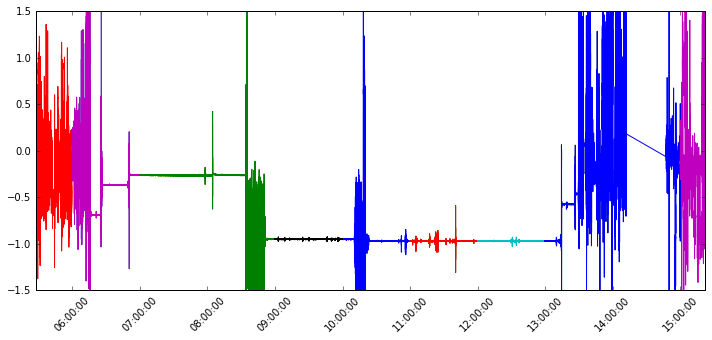

In [70]:
tz = pytz.timezone('America/Los_Angeles')
import dateutil.parser as parser
from datetime import timedelta
import calendar

_to_ts = lambda dt: calendar.timegm(dt.utctimetuple())

# start = parser.parse('2017-08-25T11:00:00-07:00') #kind of intersting?
#start = parser.parse('2017-08-13T10:00:00-07:00') #doing GRE
#start = parser.parse('2017-08-28T10:00:00-07:00') #yoga
#start = parser.parse('2017-10-06T10:00:00-07:00') # a day with yoga
start = parser.parse('2017-10-01T05:00:00-07:00') # p1965?
end = start + timedelta(hours=12)

start = _to_ts(start)
end = _to_ts(end)

plt.figure(figsize=(12, 5))
plt.xticks(rotation=45)
plt.ylim([-1.5, 1.5])

for samples, filename in loaded:
    if isinstance(samples, data_pb2.AccelerometerSamples):
        if start < samples.end_date < end or start < samples.start_date < end:
            print _parse_date(samples.start_date), len(samples.x), filename
            dates = [datetime.utcfromtimestamp(d) for d in samples.date]
            plt.plot_date(dates, samples.x, '-', tz=tz)
plt.show()

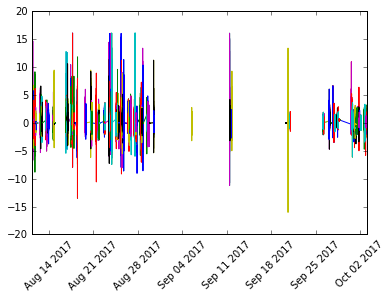

In [31]:
tz = pytz.timezone('America/Los_Angeles')

plt.xticks(rotation=45)

for samples, filename in loaded:
    if isinstance(samples, data_pb2.AccelerometerSamples):
        dates = [datetime.utcfromtimestamp(d) for d in samples.date]
        plt.plot_date(dates, samples.x, '-', tz=tz)

In [7]:
filenames = glob('/Users/carlos/vl/StopWatch/scripts/downloads/p1845*')
for filename in filenames:
    with gzip.open(filename, 'rb') as f:
        data = f.read()
        try:
            samples = data_pb2.ActivitySamples()
            samples.ParseFromString(data)
        except Exception as err:
            print 'error with', filename, str(err)
    print samples.start_date, samples.end_date, len(samples.date)


 error with /Users/carlos/vl/StopWatch/scripts/downloads/p1845-s1255-20170901T210546935Z.bin Packed element was truncated.
0.0 0.0 180856
1504184400.0 1504188000.0 0
1504180800.0 1504184400.0 0
1504188000.0 1504191600.0 2


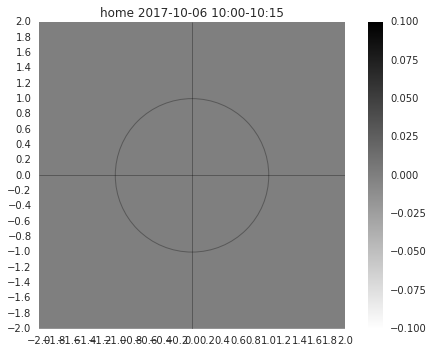

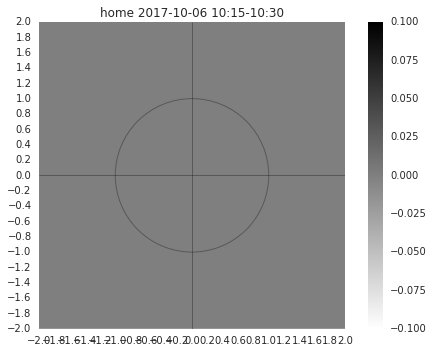

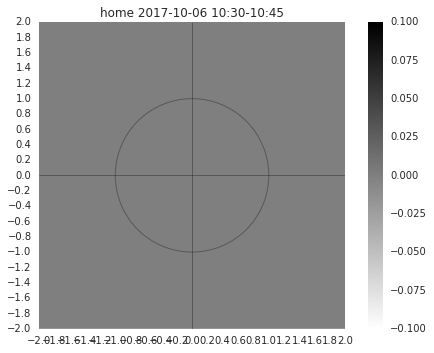

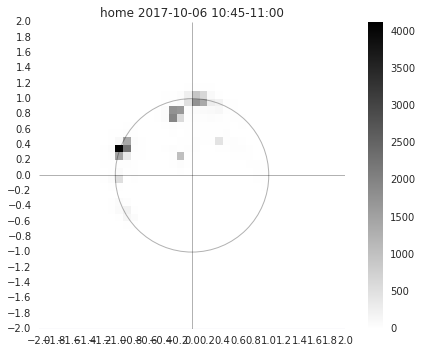

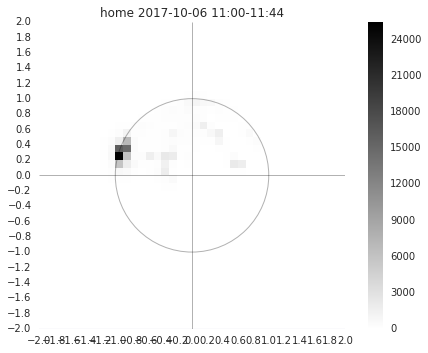

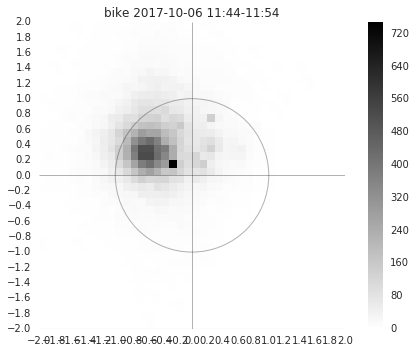

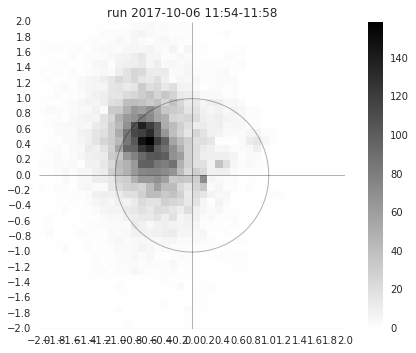

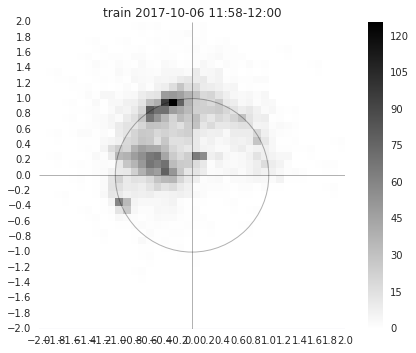

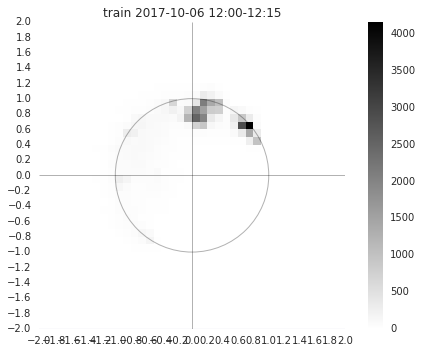

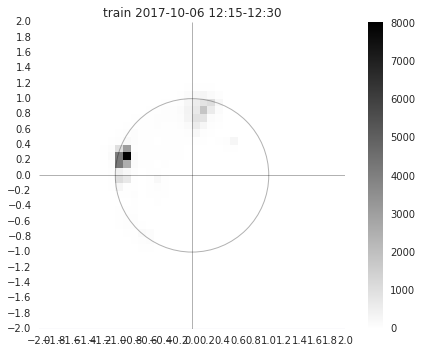

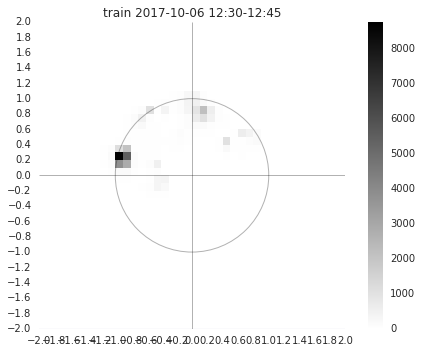

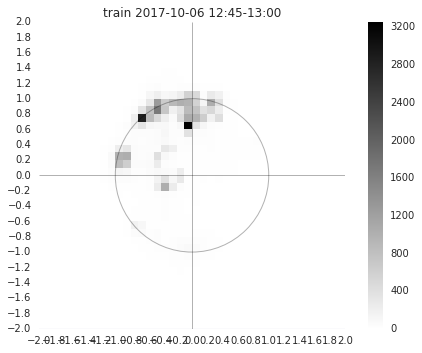

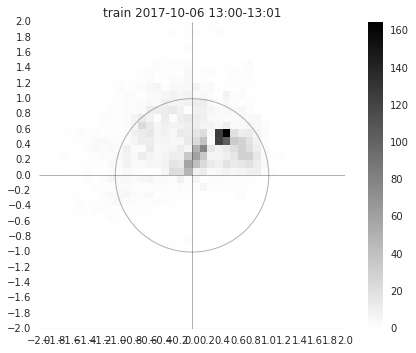

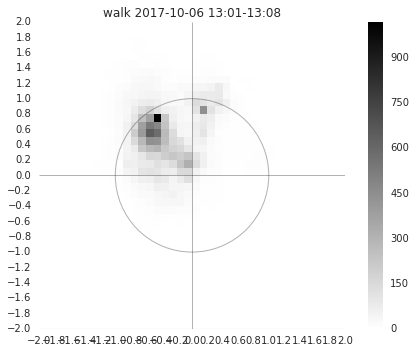

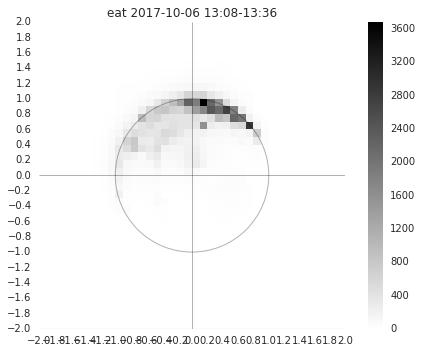

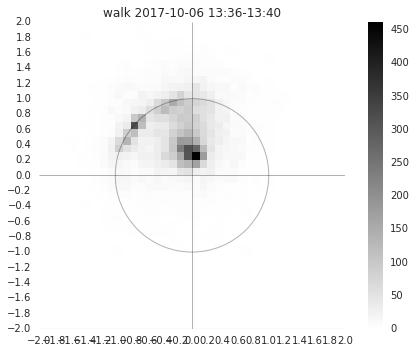

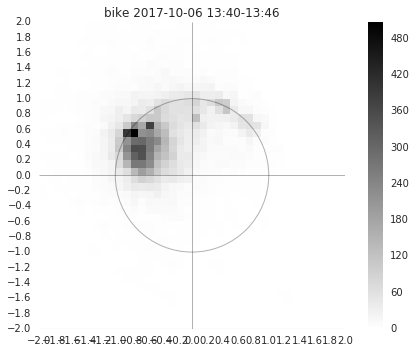

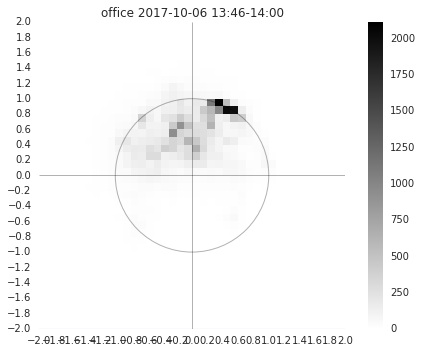

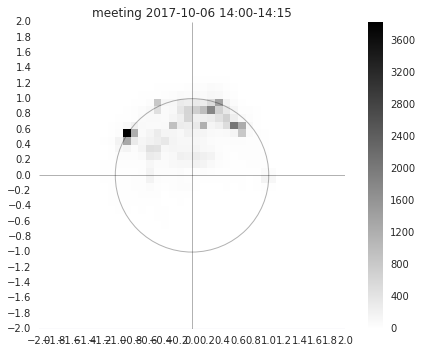

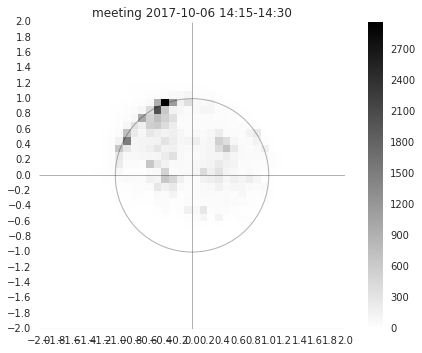

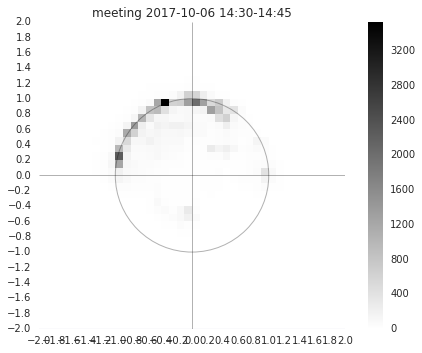

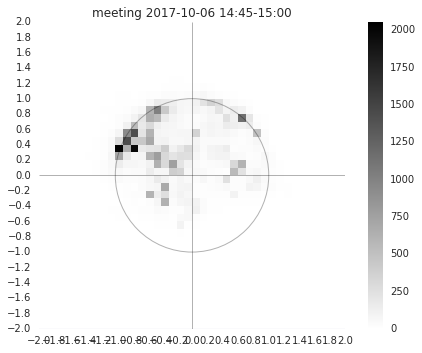

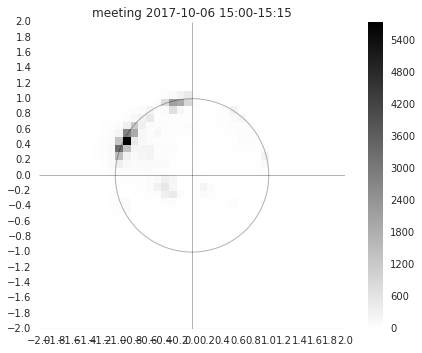

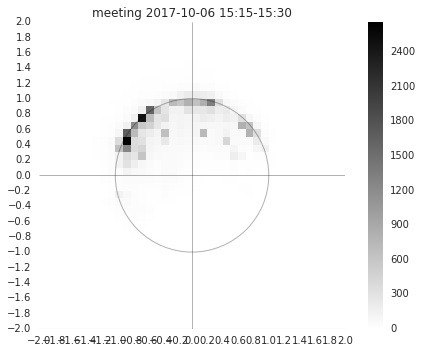

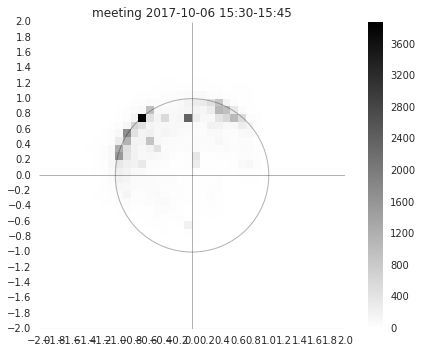

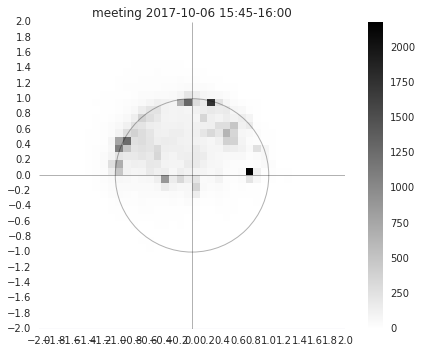

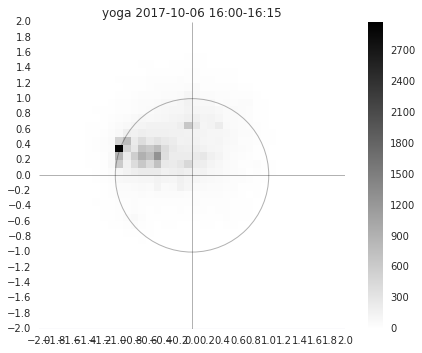

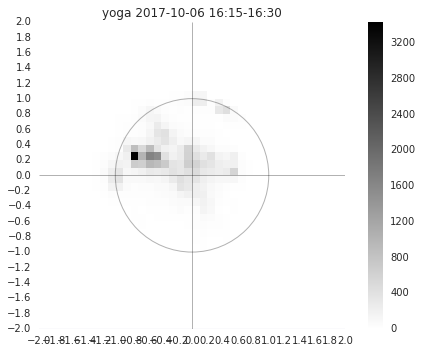

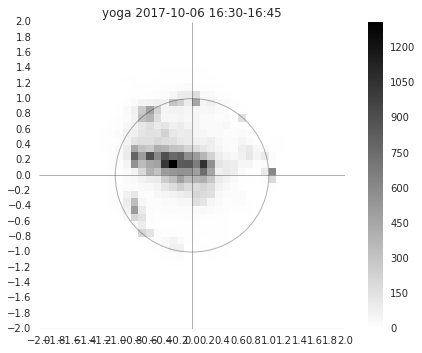

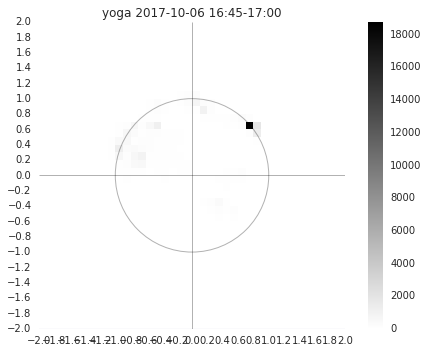

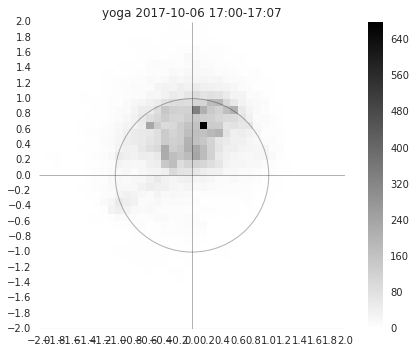

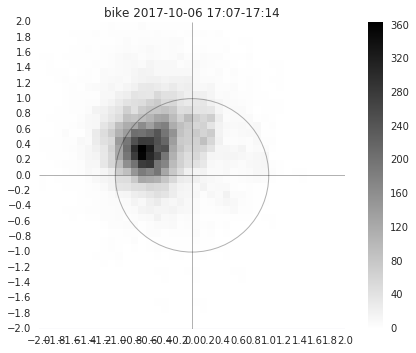

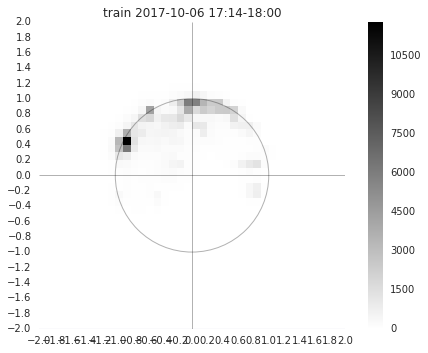

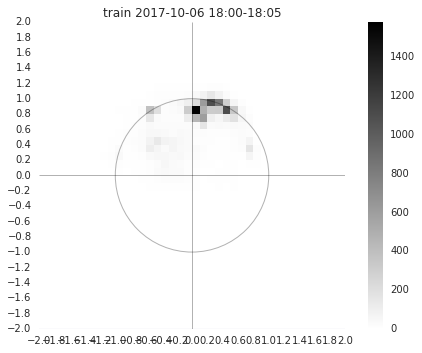

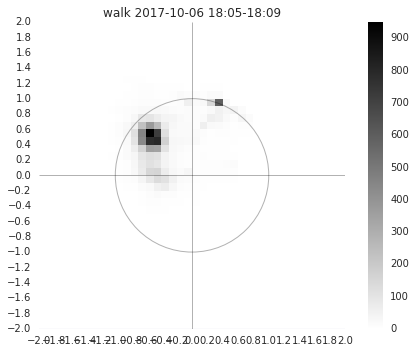

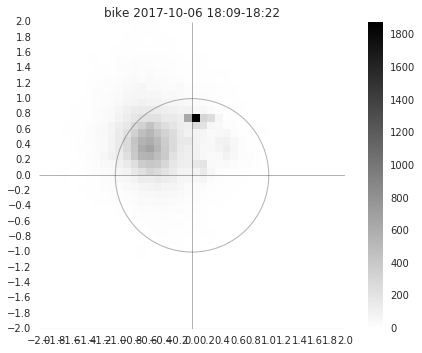

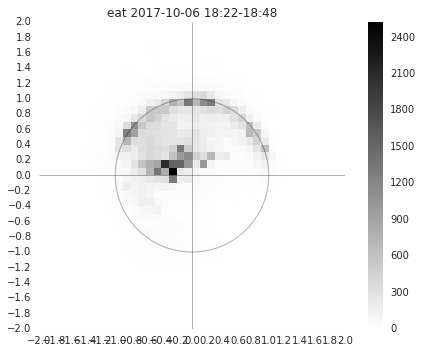

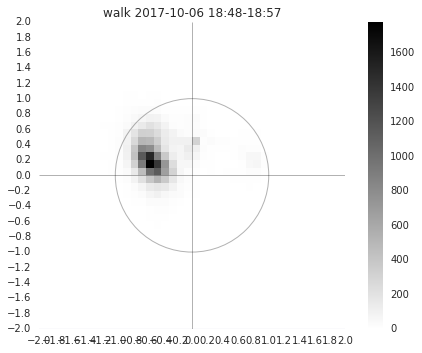

In [219]:
def _find_idx_for_time(data, target):
    for idx in range(1, len(data.date)):
        if data.date[idx-1] < target < data.date[idx]:
            return idx
    return len(data.date)-1

def _make_ranges(data, *times):
    if not isinstance(times[1], basestring):
        raise Exception('convert `times` to a list with labels interspersed.')

    start = data.start_date

    epochs = [
        timedelta(minutes=t).total_seconds()
        for t in times[0::2]
    ]
    labels = times[1::2]
    return [
        (start + epochs[idx-1], start + epochs[idx], labels[idx-1])
        for idx in range(1, len(epochs))
    ]


maps = []

def _plot_epochs(data, ranges):
    np_date = np.array(data.date)

    cm = plt.cm.gray_r

    for (st, end, label) in ranges:
        st_idx = _find_idx_for_time(data, st)
        end_idx = _find_idx_for_time(data, end)
        x = data.z[st_idx:end_idx]
        y = data.y[st_idx:end_idx]
        xlim = ylim = [-2, 2]
        # 10 or 20 is good for analysis. consider blurring as well.
        bins = 40
        tick_dist = float(xlim[1] - xlim[0]) / bins
        ticks = np.arange(xlim[0], xlim[1]+tick_dist/2, tick_dist*2)
        heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins, range=[xlim, ylim])
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

        #plt.clf()
        plt.figure()
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.xticks(ticks)
        plt.yticks(ticks)

        plt.grid(False)
        grid_kw = dict(
            color=[0, 0, 0, 0.3],
            linewidth=1,
        )
        plt.vlines(0, *ylim, **grid_kw)
        plt.hlines(0, *xlim, **grid_kw)
        gravity = plt.Circle((0, 0), 1, fill=False, **grid_kw)
        plt.gca().add_artist(gravity)

        st_parsed = _parse_date(st)
        end_parsed = _parse_date(end)
        time_lim = 5 # 5 chars for "HH:MM"
        title = '{} {} {}-{}'.format(
            label,
            st_parsed.date().isoformat(),
            st_parsed.time().isoformat()[:time_lim],
            end_parsed.time().isoformat()[:time_lim],
        )

        maps.append((title, heatmap.T))
        plt.imshow(heatmap.T, extent=extent, origin='lower', cmap=cm, interpolation='none')
        plt.colorbar()
        plt.title(title)
        plt.show()


data_root = '/Users/carlos/vl/StopWatch/scripts/downloads/'

def _p(fn, times):
    data = _load_data(os.path.join(data_root, fn))
    _plot_epochs(
        data,
        _make_ranges(data, *times),
    )

def _chunked_hour(label):
    return [0, label, 15, label, 30, label, 45, label, 60]
'''
# August 28, a day with yoga and bikes
#1p
_p('p1602-s1237-20170830T215223654Z.bin', [0, 'yoga', 31, 'bike', 38, 'office', 60])
#2p
_p('p1602-s1234-20170830T215223169Z.bin', _chunked_hour('office'))
#3p
_p('p1602-s1235-20170830T215223468Z.bin', _chunked_hour('office'))
#4p
_p('p1602-s1236-20170830T215223610Z.bin', _chunked_hour('office'))
#5p
_p('p1602-s1238-20170830T215223785Z.bin', _chunked_hour('office'))
#6p
_p('p1602-s1232-20170830T215223087Z.bin', [
    0, 'office', 28, 'bike', 33, 'walk', 36, 'wait', 41, 'train', 60])
#7p
_p('p1602-s1242-20170830T222345214Z.bin', [
    0, 'train', 23, 'walk', 25, 'bike', 47, 'home', 60])

# August 13, GRE day
# 11a
_p('p1602-s566-20170814T174318722Z.bin', [0, 'www', 56, 'essay', 60])
# 12p
_p('p1602-s567-20170814T174345900Z.bin', [0, 'essay', 31, 'texting', 32, 'exam', 60])
# 1p
_p('p1602-s568-20170814T174407938Z.bin', _chunked_hour('exam'))
# 2p
_p('p1602-s569-20170814T174418405Z.bin', [0, 'exam', 49, 'texting', 51, 'www', 60])
# 3p
_p('p1602-s570-20170814T174432014Z.bin', _chunked_hour('home'))
# 4p
_p('p1602-s573-20170814T174440177Z.bin', _chunked_hour('home'))
'''

# October 6th, a day with yoga
_p('p1577-s2508-20171007T033227869Z.bin', _chunked_hour('home')) # 10a
_p('p1577-s2546-20171009T083122250Z.bin', [
    0, 'home', 44, 'bike', 54, 'run', 58, 'train', 60]) # 11a
_p('p1577-s2555-20171009T083122427Z.bin', _chunked_hour('train')) # 12p
_p('p1577-s2688-20171009T085801096Z.bin', [
    0, 'train', 1, 'walk', 8, 'eat', 36, 'walk', 40, 'bike', 46, 'office', 60]) # 1p
_p('p1577-s2690-20171009T085801182Z.bin', _chunked_hour('meeting')) # 2p
_p('p1577-s2689-20171009T085801131Z.bin', _chunked_hour('meeting')) # 3p
# HACK add cycling between these?
_p('p1577-s2687-20171009T085601945Z.bin', _chunked_hour('yoga')) # 4p
_p('p1577-s2691-20171009T085801751Z.bin', [
    0, 'yoga', 7, 'bike', 14, 'train', 60]) # 5p
_p('p1577-s2693-20171009T085801778Z.bin', [
    0, 'train', 5, 'walk', 9, 'bike', 22, 'eat', 48, 'walk', 57, 'wait']) # 6p

In [ ]:
import seaborn as sns

plt.figure(figsize=(18, 10))

map_size = maps[0][-1].size

matrix_maps = np.zeros((len(maps), map_size))
labels = []
for idx, (label, heatmap) in enumerate(maps):
    labels.append(label)
    matrix_maps[idx, :] = heatmap.flatten()

corr = np.corrcoef(matrix_maps)
corr_annot = corr.copy()
#corr_annot[np.abs(corr_annot) < .01] = 0

hm_kwargs = dict(
    yticklabels=labels, xticklabels=labels,
    annot=True, annot_kws=dict(fontsize=6),
)

# a simpler plot with better labels:
# _=sns.heatmap(corr, **hm_kwargs)
# a clustered heatmap, can't figure out how to fix the y labels:
_=sns.clustermap(corr, **hm_kwargs)

In [39]:
class RollingAverage(object):
    # from https://www.quora.com/What-is-the-best-way-of-finding-mean-of-a-stream-at-any-point/answer/Mark-Harrison-2
    def __init__(self):
        self.reset()
    def reset(self):
        self.total = 0
        self.avg = 0.
    def update(self, item):
        self.total += 1
        self.avg += (item-self.avg)/self.total

def _get_still_ranges(x, y, z, thresh=None, minrangesize=None):
    # x, y, z should be of the same length
    results = []
    curr_st = 0
    xavg = RollingAverage()
    yavg = RollingAverage()
    zavg = RollingAverage()

    def _reset_group(idx):
        xavg.reset();xavg.update(x[idx])
        yavg.reset();yavg.update(y[idx])
        zavg.reset();zavg.update(z[idx])

    def _try_save_group(mismatch_idx):
        # we only try saving with indices that don't match, or are
        # out of bounds. So we don't want to include them in our length.
        curr_group_len = mismatch_idx-curr_st
        # we see if our group is longer than minrangesize to keep it.
        if curr_group_len >= minrangesize:
            results.append((curr_st, curr_group_len))

    _reset_group(0) # initialize state properly to first item.

    for idx in range(1, len(x)):
        # should we include this point in current?
        if (
            abs(x[idx]-xavg.avg)<thresh and
            abs(y[idx]-yavg.avg)<thresh and
            abs(z[idx]-zavg.avg)<thresh
        ):
            # since difference from average is within threshold, we keep this point.
            continue
        else:
            _try_save_group(idx)

            # we reset averages and start a new group.
            _reset_group(idx)
            curr_st = idx

    _try_save_group(idx+1)
    return results

fake_len = 20
y = z = np.zeros((fake_len, 1))
x = np.zeros((fake_len, 1))
x[10] = 10
x[11:] = 20

assert _get_still_ranges(x, y, z, thresh=5, minrangesize=2) == [(0, 10), (11, 9)]
assert _get_still_ranges(x, y, z, thresh=5, minrangesize=1) == [(0, 10), (10, 1), (11, 9)]
assert _get_still_ranges(x, y, z, thresh=50, minrangesize=1) == [(0, 20)]

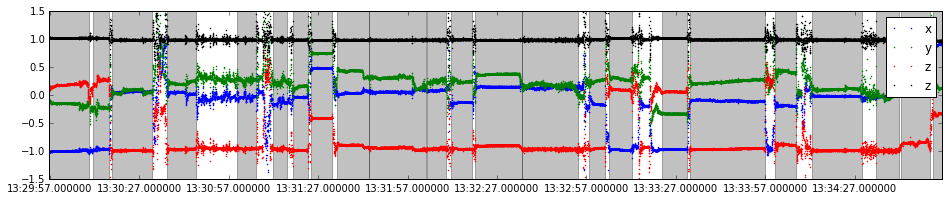

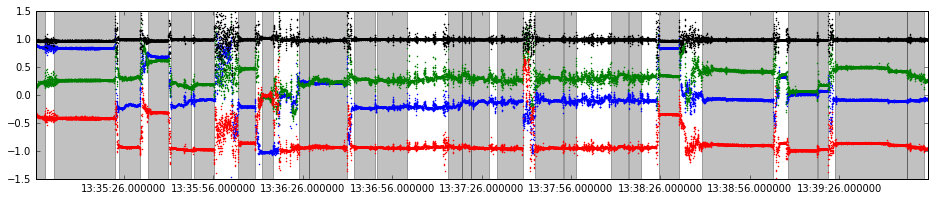

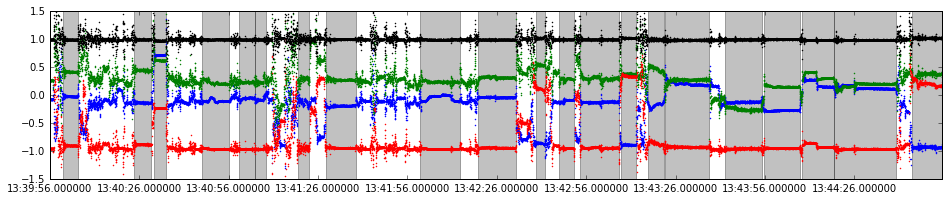

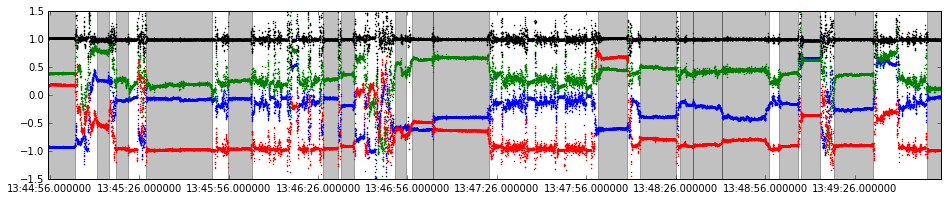

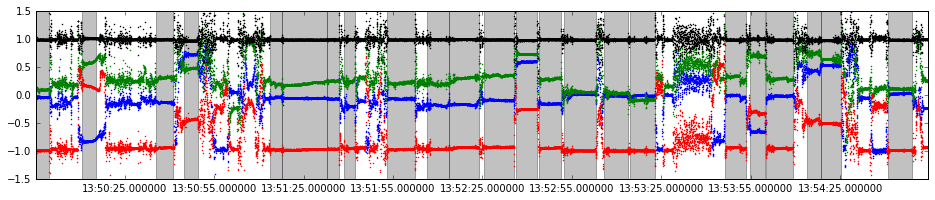

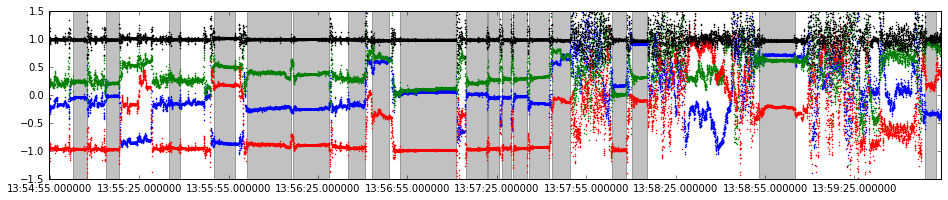

In [116]:
filename = 'p1602-s568-20170814T174407938Z.bin' # gre day
#filename = 'p1602-s1236-20170830T215223610Z.bin' # office day
data = _load_data(os.path.join(data_root, filename))

second=50
minute = 60*second

begin = 30*minute
length = 5*minute

for idx in range(6):
    st = begin + length*idx
    end = st + length
    plt.figure(figsize=(16, 3))

    dates = [_parse_date(d) for d in data.date[st:end]]
    plt.ylim([-1.5, 1.5])
    for key in ['x', 'y', 'z']:
        plt.plot_date(dates, getattr(data, key)[st:end], '.', markersize=2, label=key)
    force = np.sqrt(np.array(data.x[st:end]) ** 2 + np.array(data.y[st:end]) ** 2 + np.array(data.z[st:end]) ** 2)
    plt.plot_date(dates, force, 'k.', markersize=2, label=key)
    # Can play with threshold and minrange here.
    ranges = _get_still_ranges(
        data.x[st:end], data.y[st:end], data.z[st:end],
        #thresh=.2, minrangesize=second)
        thresh=.2, minrangesize=3*second)
    for still_range_st, still_range_len in ranges:
        plt.axvspan(
            dates[still_range_st], dates[still_range_st+still_range_len-1],
            facecolor='.2', alpha=0.3)
    if idx == 0:
        plt.legend()

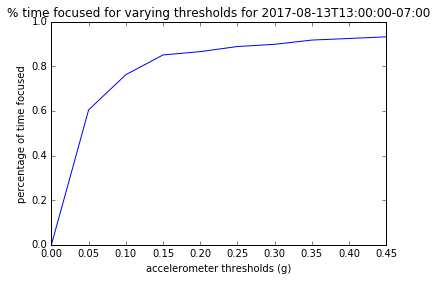

In [110]:
#data = _load_data(os.path.join(data_root, 'p1577-s2546-20171009T083122250Z.bin'))
#data = _load_data(os.path.join(data_root, 'p1965-s2001-20171002T112415611Z.bin'))
#data = _load_data(os.path.join(data_root, 'p1577-s2555-20171009T083122427Z.bin'))

threshs=[]
percents=[]

# all of it
st = 0 ; end = -1
# 5 minutes starting at 30
one_minute = 60 * 50
st = 5 * one_minute ; end = st + 5 * one_minute

d = dict(
    x=data.x[st:end],
    y=data.y[st:end],
    z=data.z[st:end],
)

for thresh in np.arange(0, .5, .05):
    threshs.append(thresh)

    ranges = _get_still_ranges(
        d['x'], d['y'], d['z'],
        thresh=thresh, minrangesize=3*second)
    still_total = sum(length for _, length in ranges)

    percents.append(still_total/float(len(d['x'])))

_=plt.plot(threshs, percents)
_=plt.title('% time focused for varying thresholds for {}'.format(_parse_date(data.start_date).isoformat()))
_=plt.xlabel('accelerometer thresholds (g)')
_=plt.ylabel('percentage of time focused')

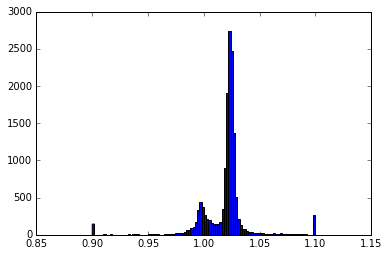

In [113]:
vector_lengths = np.sqrt(np.array(d['x']) ** 2 + np.array(d['y']) ** 2 + np.array(d['z']) ** 2)
vector_lengths = np.clip(vector_lengths, .9, 1.1)
_=plt.hist(vector_lengths, bins=100)